In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()
# index = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})
# index

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [21]:
rolling_window = 10
market.connect()
prices = []
skips = 1
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            dividends = market.query("dividends",{"ticker":ticker})
            if dividends.index.size > 0:
                dividends = p.utc_date(dividends)
                price = price.merge(dividends,on=["date","ticker"],how="left")
                price["dividend"] = price["rate"].ffill().fillna(0)
            else:
                price["dividend"] = 0
            price = Metric.DISTANCE.calculate(price,timeframe=rolling_window)
            price = Metric.COOKED_RETURN.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Indicator.EMACorr.calculate(price,timeframe=rolling_window)
            price = RiskType.COEFFICIENT_OF_VARIATION.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11272/11272 [04:21<00:00, 43.05it/s]


In [22]:
model_end = 2021
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [37]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema_corr"
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[0.1]
                                                            ,min_prices=[0.01]
                                                            ,stoplosses=[0.1]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "day" and "blacklist" in portfolio.selection_type.label \
            and portfolio.allocation_type.label == "risk" \
            and portfolio.position_type.label == "long" and ("distance" in portfolio.grouping_type.value) \
            and portfolio.max_price > portfolio.min_price:
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

2

In [38]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.88s/it]


In [39]:
a = pd.DataFrame(analysises)

In [40]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","timeframe","selection_percentage","stoploss","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
1,ema_corr,long,DISTANCE,bottom_blacklist,risk,1,0.1,0.01,1,8.397918e+36,7.224164e+37,0.9,7.746180,1.084137e+36,7.746180,1.084137e+36,7.746180
0,ema_corr,long,DISTANCE,top_blacklist,risk,1,0.1,0.01,1,2.546364e+09,1.252736e+11,0.9,14.102362,1.805629e+08,14.102362,1.805629e+08,14.102362


In [41]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [42]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

In [43]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# # Titles for each subplot
# titles = ["Long", "Short"]

# # Iterate over directions and corresponding axes
# for i, position_type in enumerate(["long", "short"]):
#     d_analysis = a[a["position_type"] == position_type]
#     axes[i].scatter(
#         d_analysis["portfolio_std"],
#         d_analysis["pnl"],
#         c=d_analysis["color"],
#         alpha=0.8,
#         edgecolors="w",
#     )
#     axes[i].set_title(titles[i])
#     axes[i].set_xlabel("return_to_risk")
#     axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the combined plot
# plt.show()

In [47]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

In [48]:
trades["adjclose"].min()

np.float64(0.01)

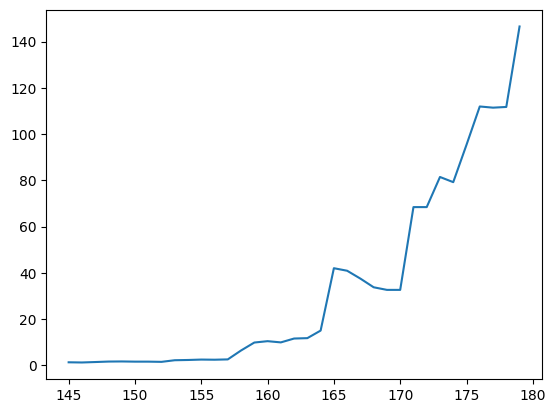

In [53]:
portfolio["weekday"] = portfolio["date"].dt.weekday
averaged_portfolio = portfolio.groupby("day").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["return"]
plt.plot(averaged_portfolio["pv"][145:180].cumprod())
plt.show()

In [50]:
# portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio[pm.timeframe.value].astype(str)
# ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
#     kind="line",
#     figsize=(12, 6),
#     title="Mean Returns by Exposure per Year and Quarter"
# )

# # Set y-axis to have more precise ticks
# ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# # Move y-ticks to the right side
# ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# # Optionally adjust the number of ticks for better precision
# ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# # Add grid lines
# ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# # Display the plot
# plt.tight_layout()
# plt.show()

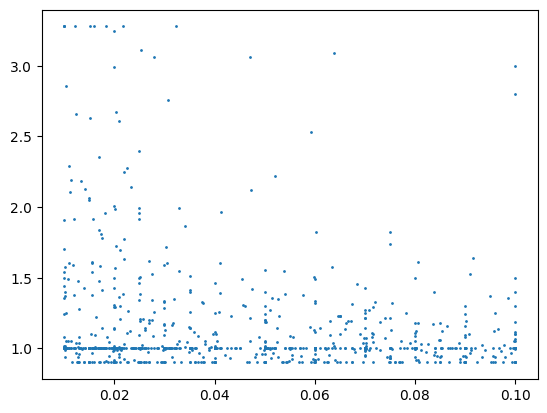

In [52]:
plt.scatter(trades["adjclose"],trades["winsorized_return"],s=1)
plt.show()